<a href="https://colab.research.google.com/github/MaryaMalyshkina/prolog/blob/main/prolog_deviations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ultralytics -q

In [2]:
from ultralytics import YOLO
import cv2
from google.colab.patches import cv2_imshow

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
import json

from scipy.spatial.distance import directed_hausdorff

In [3]:
# Загрузка модели
model = YOLO("/content/best.pt")

# Отрисовка bounding boxes предсказаний


0: 640x640 2 cracks, 2 joints, 1059.3ms
Speed: 10.5ms preprocess, 1059.3ms inference, 16.0ms postprocess per image at shape (1, 3, 640, 640)
[[389.6474609375, 354.0303955078125, 526.2743530273438, 638.1045532226562], [263.17144775390625, 0.837615966796875, 413.09783935546875, 342.2396545410156], [496.2464599609375, 346.71051025390625, 639.784912109375, 369.54827880859375], [0.896209716796875, 350.49310302734375, 280.325927734375, 369.68035888671875]]


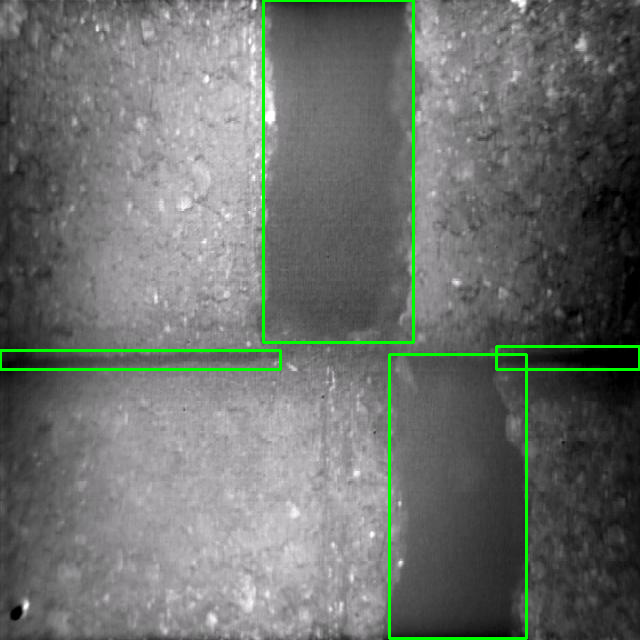

-1

In [4]:
# Загрузка изображения
img = cv2.imread("/content/drive/MyDrive/svik54.v3-prolog_1500.yolov11/test/images/T-01-23-31-C-Side-P-4676-3-A-93-6-L-0_png.rf.00f8218f743232950473d3bff56fb3d2.jpg")

# Предсказание
results = model(img)

# Извлечение предсказанных bounding boxes
pred_boxes = []
for result in results:
    boxes = result.boxes
    for box in boxes:
        x1, y1, x2, y2 = box.xyxy[0].tolist()  # xyxy формат: [x1, y1, x2, y2]
        pred_boxes.append([x1, y1, x2, y2])

print(pred_boxes)

for box in pred_boxes:
    x1, y1, x2, y2 = int(box[0]), int(box[1]), int(box[2]), int(box[3]),
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
cv2_imshow(img)
cv2.waitKey(0)

# Функции для конвертации между форматами из xyxy в yolo и обратно.

In [5]:
def xyxy_to_yolo(xyxy_box, img_width, img_height):
    """
    Конвертирует [x1, y1, x2, y2] в [x_center, y_center, width, height]
    с нормированием относительно размеров изображения
    """
    x1, y1, x2, y2 = xyxy_box

    # Вычисляем центр
    x_center = (x1 + x2) / 2.0
    y_center = (y1 + y2) / 2.0

    # Вычисляем ширину и высоту
    width = x2 - x1
    height = y2 - y1

    # Нормируем относительно размеров изображения
    x_center_norm = x_center / img_width
    y_center_norm = y_center / img_height
    width_norm = width / img_width
    height_norm = height / img_height

    return [x_center_norm, y_center_norm, width_norm, height_norm]

In [6]:
def yolo_to_xyxy(yolo_box, img_width, img_height):
    """
    Конвертирует [x_center, y_center, width, height] (нормированные)
    в [x1, y1, x2, y2] (абсолютные пиксели)
    """
    x_center_norm, y_center_norm, width_norm, height_norm = yolo_box

    # Переводим в абсолютные координаты
    x_center = x_center_norm * img_width
    y_center = y_center_norm * img_height
    width = width_norm * img_width
    height = height_norm * img_height

    # Вычисляем углы
    x1 = x_center - width/2
    y1 = y_center - height/2
    x2 = x_center + width/2
    y2 = y_center + height/2

    return [x1, y1, x2, y2]

# Функция для загрузки аннотаций для изображения

1. Загружает изображение для получения размеров

2. Парсит полигоны YOLO формата

3. Создает бинарные маски из полигонов

4. Вычисляет bounding boxes из полигонов (минимальный охватывающий прямоугольник для маски)

5. Конвертирует bbox в нормированный YOLO формат 0-1 (относительно размера изображения).

In [7]:
def load_true_annotations(label_path, img_path):
    """
    Загружает истинные разметки из файла YOLO формата
    Возвращает: маски, bounding boxes, классы
    """
    # Загружаем изображение для получения размеров
    img = cv2.imread(str(img_path))
    if img is None:
        raise ValueError(f"Не удалось загрузить изображение: {img_path}")

    img_height, img_width = img.shape[:2]

    masks = []
    boxes = []
    classes = []

    # Проверяем существование файла разметки
    if not Path(label_path).exists():
        print(f"Файл разметки не найден: {label_path}")
        return masks, boxes, classes

    try:
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) < 9:  # минимально: class_id + 4 точки (8 координат)
                    continue

                # Извлекаем class_id
                class_id = int(parts[0])

                # Извлекаем координаты полигона
                coords = np.array(parts[1:], dtype=np.float32)

                # 1. Создаем маску из полигона
                polygon_norm = coords.reshape(-1, 2)
                polygon_abs = (polygon_norm * [img_width, img_height]).astype(np.int32)

                mask = np.zeros((img_height, img_width), dtype=np.uint8)
                cv2.fillPoly(mask, [polygon_abs], 1)
                masks.append(mask)

                # 2. Вычисляем bounding box из полигона
                x_coords = polygon_abs[:, 0]
                y_coords = polygon_abs[:, 1]

                x_min, x_max = x_coords.min(), x_coords.max()
                y_min, y_max = y_coords.min(), y_coords.max()

                # Конвертируем в YOLO формат: [x_center, y_center, width, height] (нормированные)
                x_center = ((x_min + x_max) / 2) / img_width
                y_center = ((y_min + y_max) / 2) / img_height
                width = (x_max - x_min) / img_width
                height = (y_max - y_min) / img_height

                boxes.append([x_center, y_center, width, height])
                classes.append(class_id)

    except Exception as e:
        print(f"Ошибка загрузки разметки {label_path}: {e}")

    return masks, boxes, classes

In [8]:
# проверка работы функции
img_path = '/content/drive/MyDrive/svik54.v3-prolog_1500.yolov11/test/images/T-01-23-31-C-Side-P-4676-3-A-93-6-L-0_png.rf.00f8218f743232950473d3bff56fb3d2.jpg'
label_path = '/content/drive/MyDrive/svik54.v3-prolog_1500.yolov11/test/labels/T-01-23-31-C-Side-P-4676-3-A-93-6-L-0_png.rf.00f8218f743232950473d3bff56fb3d2.txt'
load_true_annotations(label_path, img_path)

([array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
  array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
  array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
  array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)],
 [[np.float64(0.5296875),
   np.float64(0.2703125),
   np.float64(0

# Функция для нахождения оптимальных пар "истинная маска - предсказанная маска" на основе их перекрытия (IoU)

Создается матрица размером [количество истинных масок] × [количество предсказанных масок].

Для каждой пары вычисляется IoU:

1) Пересечение (intersection): пиксели, где обе маски = 1 (True)

2) Объединение (union): пиксели, где хотя бы одна маска = 1

3) IoU = пересечение / объединение.

Если маски совпадают идеально, IoU = 1.0

Логика сопоставления:

Каждой истинной маске ищется лучшее предсказание (с максимальным IoU)

Предсказание должно:

- не быть уже использованным для другой истинной маски

- иметь IoU > порога (по умолчанию 0.5).

Это жадный алгоритм — берется первый подходящий вариант по порядку.

Предсказания с IoU < 0.5 для всех истинных масок — ложные срабатывания (false positives)

Истинные маски, для которых не нашлось предсказаний с IoU > 0.5 — пропущенные объекты (false negatives).

In [9]:
def match_predictions(true_masks, pred_masks, iou_threshold=0.5):
    """
    Сопоставляет истинные и предсказанные маски по IoU
    Возвращает список пар индексов (idx_true, idx_pred)
    """
    if not true_masks or not pred_masks:
        return []

    matches = []
    used_pred = set()

    # Вычисляем IoU матрицу
    iou_matrix = np.zeros((len(true_masks), len(pred_masks)))

    for i, true_mask in enumerate(true_masks):
        for j, pred_mask in enumerate(pred_masks):
            intersection = np.logical_and(true_mask, pred_mask).sum()
            union = np.logical_or(true_mask, pred_mask).sum()
            iou_matrix[i, j] = intersection / union if union > 0 else 0

    # сопоставление масок
    for i in range(len(true_masks)):
        best_iou = iou_threshold
        best_j = -1

        for j in range(len(pred_masks)):
            if j not in used_pred and iou_matrix[i, j] > best_iou:
                best_iou = iou_matrix[i, j]
                best_j = j

        if best_j != -1:
            matches.append((i, best_j))
            used_pred.add(best_j)

    return matches

# Функция для нахождения смещений bounding boxes

Сравнивает пары истинных и предсказанных bounding boxes и вычисляет количественные метрики того, насколько они отличаются:
* смещение центров,
* относительное смещение центров (относительно истинного бокса),
* отношение площадей,
* разница отношений ширина/высота.

Боксы представлены в нормированном формате YOLO:

[x_center, y_center, width, height].

Все значения в диапазоне [0, 1] (относительно размеров изображения).

In [10]:
def calculate_box_deviations(true_boxes, pred_boxes, img_size=(640, 640)):
    """
    Вычисляет отклонения bounding boxes
    """
    deviations = {
        'center_shift_px': [],      # Смещение центров
        'center_shift_rel': [],     # Смещение центров (относительно размера)
        'size_ratio': [],           # Отношение размеров
        'aspect_ratio_diff': [],    # Разница соотношений сторон

    }

    for true_box, pred_box in zip(true_boxes, pred_boxes):
        # Формат: [x_center, y_center, width, height] (нормированные)

        # 1. Смещение центра (в пикселях)
        center_shift_px = np.sqrt(
            ((true_box[0] - pred_box[0]) * img_size[0])**2 +
            ((true_box[1] - pred_box[1]) * img_size[1])**2
        )

        # 2. Смещение центра (относительно размера объекта)
        center_shift_rel = np.sqrt(
            ((true_box[0] - pred_box[0]) / true_box[2])**2 +
            ((true_box[1] - pred_box[1]) / true_box[3])**2
        )

        # 3. Отношение размеров
        size_ratio = (pred_box[2] * pred_box[3]) / (true_box[2] * true_box[3])

        # 4. Разница соотношений сторон
        aspect_true = true_box[2] / true_box[3]
        aspect_pred = pred_box[2] / pred_box[3]
        aspect_ratio_diff = abs(aspect_true - aspect_pred)

        deviations['center_shift_px'].append(center_shift_px)
        deviations['center_shift_rel'].append(center_shift_rel)
        deviations['size_ratio'].append(size_ratio)
        deviations['aspect_ratio_diff'].append(aspect_ratio_diff)

    return deviations

# Функция для вычисления отклонений масок сегментации

Функция сравнивает пары бинарных масок (истинную и предсказанную) и вычисляет разные метрики качества сегментации:
1. IoU (Intersection over Union), процент перекрытия масок
2. Dice Coefficient, похожесть масок, Dice = 2|A ∩ B| / (|A| + |B|)
3. Hausdorff Distance, максимальное расстояние между контурами масок
4. Average Surface Distance, среднее расстояние между границами масок
5. Centroid Distance, расстояние между центрами масс объектов
6. Area Ratio, отношение площадей предсказанной маски и истинной.

In [11]:
def calculate_mask_deviations(true_masks, pred_masks):
    """
    Вычисляет отклонения масок сегментации
    """
    deviations = {
        'iou': [],
        'dice': [],
        'hausdorff_distance': [],      # Максимальное расстояние между контурами
        'average_surface_distance': [], # Среднее расстояние между поверхностями
        'centroid_distance': [],       # Расстояние между центрами масс
        'area_ratio': []              # Отношение площадей
    }

    for true_mask, pred_mask in zip(true_masks, pred_masks):
        # 1. IoU (Intersection over Union)
        intersection = np.logical_and(true_mask, pred_mask).sum()
        union = np.logical_or(true_mask, pred_mask).sum()
        iou = intersection / union if union > 0 else 0

        # 2. Dice coefficient
        dice = (2 * intersection) / (true_mask.sum() + pred_mask.sum())

        # 3. Hausdorff distance (для контуров)
        true_points = np.column_stack(np.where(true_mask > 0))
        pred_points = np.column_stack(np.where(pred_mask > 0))

        if len(true_points) > 0 and len(pred_points) > 0:
            hd = max(
                directed_hausdorff(true_points, pred_points)[0],
                directed_hausdorff(pred_points, true_points)[0]
            )
        else:
            hd = np.nan

        # 4. Average surface distance
        if len(true_points) > 0 and len(pred_points) > 0:
            from scipy.spatial import cKDTree
            tree_pred = cKDTree(pred_points)
            dist_true_to_pred = tree_pred.query(true_points)[0].mean()

            tree_true = cKDTree(true_points)
            dist_pred_to_true = tree_true.query(pred_points)[0].mean()

            asd = (dist_true_to_pred + dist_pred_to_true) / 2
        else:
            asd = np.nan

        # 5. Центроиды
        from scipy.ndimage import center_of_mass
        true_centroid = center_of_mass(true_mask)
        pred_centroid = center_of_mass(pred_mask)
        centroid_dist = np.linalg.norm(
            np.array(true_centroid) - np.array(pred_centroid)
        )

        # 6. Отношение площадей
        area_ratio = pred_mask.sum() / true_mask.sum()

        deviations['iou'].append(iou)
        deviations['dice'].append(dice)
        deviations['hausdorff_distance'].append(hd)
        deviations['average_surface_distance'].append(asd)
        deviations['centroid_distance'].append(centroid_dist)
        deviations['area_ratio'].append(area_ratio)

    return deviations

# Функция для построения гистограмм отклонений

Функция строит гистограммы для метрик отклонений истинных и предсказанных bounding boxes и масок.

In [12]:
def visualize_deviations(deviations_box, deviations_mask):
    """
    Визуализирует распределения отклонений
    """
    fig, axes = plt.subplots(5, 2, figsize=(20, 15))
    axes = axes.flatten()

    metrics_box = [
        ('center_shift_px', 'Смещение центра (px)', 0),
        ('center_shift_rel', 'Отн. смещение центра', 1),
        ('size_ratio', 'Отношение площадей', 2),
        ('aspect_ratio_diff', 'Разница aspect ratio', 3)
    ]

    metrics_mask = [
        ('iou', 'IoU', 4),
        ('dice', 'Dice', 5),
        ('hausdorff_distance', 'Hausdorff distance', 6),
        ('average_surface_distance', 'Avg surface distance', 7),
        ('centroid_distance', 'Distance центроидов', 8),
        ('area_ratio', 'Отношение площадей', 9)
    ]

    # Bounding boxes отклонения
    for metric, title, idx in metrics_box:
        data = deviations_box[metric]
        axes[idx].hist(data, bins=30, alpha=0.7, edgecolor='black')
        axes[idx].axvline(np.mean(data), color='red', linestyle='--',
                         label=f'Mean: {np.mean(data):.3f}')
        axes[idx].set_title(f'BBox: {title}')
        axes[idx].set_xlabel('Значение')
        axes[idx].set_ylabel('Частота')
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)

    # Маски отклонения
    for metric, title, idx in metrics_mask:
        data = [x for x in deviations_mask[metric] if not np.isnan(x)]
        if len(data) > 0:
            axes[idx].hist(data, bins=30, alpha=0.7, edgecolor='black', color='green')
            axes[idx].axvline(np.mean(data), color='red', linestyle='--',
                             label=f'Mean: {np.mean(data):.3f}')
            axes[idx].set_title(f'Mask: {title}')
            axes[idx].set_xlabel('Значение')
            axes[idx].set_ylabel('Частота')
            axes[idx].legend()
            axes[idx].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('deviation_distributions.png', dpi=150, bbox_inches='tight')
    plt.show()

# Статистические характеристики отклонений

Функция вычисляет стандартные статистические характеристики для метрик отклонений истинных и предсказанных bounding boxes и масок:

* Среднее (mean)   
* Стандартное отклонение (std)
* Медиана (median)   
* Квартили (q25, q75)
* Минимум/максимум.

In [13]:
def analyze_deviations_statistically(all_deviations_box, all_deviations_mask):
    """
    Статистический анализ отклонений
    """
    stats = {}

    # Для bounding boxes
    for metric, values in all_deviations_box.items():
        if values:  # Проверяем что список не пустой
            stats[f'bbox_{metric}'] = {
                'mean': float(np.mean(values)),
                'std': float(np.std(values)),
                'median': float(np.median(values)),
                'q25': float(np.percentile(values, 25)),
                'q75': float(np.percentile(values, 75)),
                'min': float(np.min(values)),
                'max': float(np.max(values)),
                'cv': float(np.std(values) / np.mean(values)) if np.mean(values) > 0 else 0
            }
        else:
            stats[f'bbox_{metric}'] = {
                'mean': 0, 'std': 0, 'median': 0, 'q25': 0, 'q75': 0,
                'min': 0, 'max': 0, 'cv': 0
            }

    # Для масок
    for metric, values in all_deviations_mask.items():
        # Фильтруем NaN значения и проверяем что есть данные
        valid_values = [v for v in values if not np.isnan(v)] if values else []

        if valid_values:
            stats[f'mask_{metric}'] = {
                'mean': float(np.mean(valid_values)),
                'std': float(np.std(valid_values)),
                'median': float(np.median(valid_values)),
                'q25': float(np.percentile(valid_values, 25)),
                'q75': float(np.percentile(valid_values, 75)),
                'min': float(np.min(valid_values)),
                'max': float(np.max(valid_values))
            }
        else:
            stats[f'mask_{metric}'] = {
                'mean': 0, 'std': 0, 'median': 0, 'q25': 0, 'q75': 0,
                'min': 0, 'max': 0
            }

    # Создаем DataFrame для удобства
    df_stats = pd.DataFrame(stats).T

    print("Статистический анализ отклонений")

    if df_stats.empty:
        print("Нет данных для статистического анализа!")
    else:
        print(df_stats.round(4))

    df_stats.to_csv('class_statistics.csv', encoding='utf-8-sig')

    return df_stats

# Анализ отклонений по классам

Функция вычисляет метрики отклонений отдельно для каждого класса объектов.

In [14]:
def plot_summary_charts(unique_classes, class_names, all_metrics_data, save_plots, plot_dir):
    """Отдельные графики для BBox и Mask метрик"""

    class_labels = [class_names.get(cid, f'Class_{cid}') for cid in unique_classes]
    x_pos = np.arange(len(class_labels))

    # BBox метрики
    print("Графики для BBох метрик")

    bbox_metrics_found = False

    for metric_name, data in all_metrics_data.items():
        if 'bbox' in data and data['bbox']:
            bbox_metrics_found = True
            bbox_values = [data['bbox'].get(cid, 0) for cid in unique_classes]

            # Строим график только если есть ненулевые значения
            if any(v > 0 for v in bbox_values):
                plt.figure(figsize=(6, 4))
                bars = plt.bar(class_labels, bbox_values, color='skyblue', edgecolor='black')

                plt.title(f'BBox: {metric_name} по классам', fontsize=14, fontweight='bold')
                plt.xlabel('Классы', fontsize=12)
                plt.ylabel('Ошибка', fontsize=12)
                plt.xticks(rotation=45)
                plt.grid(axis='y', alpha=0.3)

                for bar, value in zip(bars, bbox_values):
                    if value > 0:
                        plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
                                f'{value:.3f}', ha='center', va='bottom', fontsize=9)

                plt.tight_layout()

                if save_plots:
                    safe_name = "".join(c if c.isalnum() else "_" for c in metric_name)
                    filename = f"{plot_dir}/bbox_only_{safe_name}.png"
                    plt.savefig(filename, dpi=150, bbox_inches='tight')
                    print(f" BBox график сохранен: {filename}")

                plt.show()
                plt.close()
            else:
                print(f"BBox метрика '{metric_name}': все значения нулевые")

    if not bbox_metrics_found:
        print(" Нет данных по BBox метрикам")

    #  Mask метрики
    print("Графики для mask метрик")

    mask_metrics_found = False

    for metric_name, data in all_metrics_data.items():
        if 'mask' in data and data['mask']:  # Есть данные по Mask
            mask_metrics_found = True
            mask_values = [data['mask'].get(cid, 0) for cid in unique_classes]

            # Строим график только если есть ненулевые значения
            if any(v > 0 for v in mask_values):
                plt.figure(figsize=(6, 4))
                bars = plt.bar(class_labels, mask_values, color='lightcoral', edgecolor='black')

                plt.title(f'Mask: {metric_name} по классам', fontsize=14, fontweight='bold')
                plt.xlabel('Классы', fontsize=12)
                plt.ylabel('Ошибка', fontsize=12)
                plt.xticks(rotation=45)
                plt.grid(axis='y', alpha=0.3)

                # Добавляем значения
                for bar, value in zip(bars, mask_values):
                    if value > 0:
                        plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
                                f'{value:.3f}', ha='center', va='bottom', fontsize=9)

                plt.tight_layout()

                if save_plots:
                    safe_name = "".join(c if c.isalnum() else "_" for c in metric_name)
                    filename = f"{plot_dir}/mask_only_{safe_name}.png"
                    plt.savefig(filename, dpi=150, bbox_inches='tight')
                    print(f"Mask график сохранен: {filename}")

                plt.show()
                plt.close()
            else:
                print(f"Mask метрика '{metric_name}': все значения нулевые")

    if not mask_metrics_found:
        print(" Нет данных по Mask метрикам")

In [15]:
def create_statistics_dataframe(class_stats, class_names):
    """Создает DataFrame со статистикой"""

    data = []
    for class_id, stats in class_stats.items():
        class_name = class_names.get(class_id, f'Class_{class_id}')

        for metric_name, metric_stats in stats.items():
            row = {
                'class_id': class_id,
                'class_name': class_name,
                'metric': metric_name,
                'mean': metric_stats['mean'],
                'std': metric_stats['std'],
                'count': metric_stats.get('count', 0)
            }
            data.append(row)

    if data:
        df = pd.DataFrame(data)

        pivot_df = df.pivot_table(
            index=['class_id', 'class_name'],
            columns='metric',
            values=['mean', 'std']
        )

        print("Статистика отклоненеий по классам")

        for class_id in sorted(class_stats.keys()):
            class_name = class_names.get(class_id, f'Class_{class_id}')
            print(f"\n Класс: {class_name} (ID: {class_id})")

            if class_id in class_stats:
                for metric, values in class_stats[class_id].items():
                    print(f"  {metric:30} mean={values['mean']:.4f}, std={values['std']:.4f}, n={values.get('count', 'N/A')}")

        return df
    else:
        print("Нет данных для создания статистики")
        return pd.DataFrame()

In [16]:
def analyze_deviations_by_class(true_classes, pred_classes, deviations_box, deviations_mask,
                                class_names=None, save_plots=False, plot_dir='class_analysis_plots'):
    """
    Анализ отклонений по классам объектов с построением диаграмм

    Args:
        true_classes: список истинных классов
        pred_classes: список предсказанных классов
        deviations_box: словарь с отклонениями для bounding boxes
        deviations_mask: словарь с отклонениями для масок
        class_names: словарь или список названий классов (опционально)
        save_plots: сохранять ли графики в файлы
        plot_dir: директория для сохранения графиков
    """

    # Создаем директорию для графиков если нужно
    if save_plots:
        Path(plot_dir).mkdir(parents=True, exist_ok=True)

    unique_classes = set(true_classes + pred_classes)

    # Преобразуем в список и сортируем для последовательности
    unique_classes = sorted(list(unique_classes))

    # Если не заданы имена классов, создаем числовые
    if class_names is None:
        class_names = {class_id: f"Class_{class_id}" for class_id in unique_classes}
    elif isinstance(class_names, list):
        class_names = {i: name for i, name in enumerate(class_names)}

    class_stats = {}
    all_metrics_data = {}  # Для сбора данных по всем метрикам

    # 1. Собираем статистику
    for class_id in unique_classes:
        # Индексы для данного класса
        idx_true = [i for i, c in enumerate(true_classes) if c == class_id]
        idx_pred = [i for i, c in enumerate(pred_classes) if c == class_id]

        if idx_true and idx_pred:
            class_deviations = {}

            # BBox метрики
            bbox_data = {}
            for metric in deviations_box.keys():
                values = [deviations_box[metric][i] for i in idx_true
                         if i < len(deviations_box[metric])]
                if values:
                    mean_val = np.mean(values)
                    std_val = np.std(values)
                    class_deviations[f'bbox_{metric}'] = {
                        'mean': mean_val,
                        'std': std_val,
                        'count': len(values)
                    }
                    bbox_data[metric] = mean_val

                    # Сохраняем для общего графика
                    if metric not in all_metrics_data:
                        all_metrics_data[metric] = {'bbox': {}, 'mask': {}}
                    all_metrics_data[metric]['bbox'][class_id] = mean_val

            # Mask метрики
            mask_data = {}
            for metric in deviations_mask.keys():
                values = [deviations_mask[metric][i] for i in idx_true
                         if i < len(deviations_mask[metric]) and not np.isnan(deviations_mask[metric][i])]
                if values:
                    mean_val = np.mean(values)
                    std_val = np.std(values)
                    class_deviations[f'mask_{metric}'] = {
                        'mean': mean_val,
                        'std': std_val,
                        'count': len(values)
                    }
                    mask_data[metric] = mean_val

                    # Сохраняем для общего графика
                    if metric not in all_metrics_data:
                        all_metrics_data[metric] = {'bbox': {}, 'mask': {}}
                    all_metrics_data[metric]['mask'][class_id] = mean_val

            class_stats[class_id] = class_deviations

    #  Строим сводные графики по всем классам
    if all_metrics_data:
        plot_summary_charts(unique_classes, class_names,
                           all_metrics_data, save_plots, plot_dir)

    # Создаем DataFrame для удобного просмотра
    df_stats = create_statistics_dataframe(class_stats, class_names)

    return df_stats, class_stats

# Итоговая функция для анализа

Функция выполняет полную оценку качества модели сегментации путем сравнения предсказанных объектов с истинной разметкой и вычисления различных метрик отклонений.

1.  Инициализация структур для хранения результатов
2. Обработка каждого изображения

 Для каждого изображения в тестовом наборе:
 * Получение предсказаний модели,
* Загрузка истинной разметки,
* Извлечение предсказанных объектов (маски сегментации (бинарные), bounding boxes (нормированные, формат YOLO: [x_center, y_center, width, height]), классы объектов.
* Сопоставление объектов (пары "истинный объект - предсказанный объект").

3. Вычисление отклонений

Для каждой совпавшей пары объектов:

а) Отклонения bounding boxes:
* Смещение центра (в пикселях и относительно размера),
* Отношение размеров (площадь pred / площадь true),
* Разница соотношений сторон

б) Отклонения масок:

* IoU (Intersection over Union) - основная метрика сегментации,
* Коэффициент Dice - альтернатива IoU,
* Расстояние Хаусдорфа - максимальное расстояние между контурами,
* Среднее расстояние между поверхностями,
* Расстояние между центрами масс,
* Отношение площадей масок

4. Сохранение результатов
5. Обработка ошибок
6. Визуализация и анализ

* Визуализация распределений отклонений (гистограммы, box plots)
* Статистический анализ (средние, медианы, процентили, стандартные отклонения)
* Анализ по классам - сравнение метрик для разных классов

7. Экспорт результатов

* CSV файл с таблицей статистики

* JSON файл с полными результатами:

* Общая статистика

* Статистика по классам.

In [17]:
def evaluate_yolo_seg_deviations(model, test_dataset_path, conf_threshold=0.25):
    """
    Полная оценка отклонений для YOLO11S-seg
    """

    # Загружаем тестовые данные
    test_images = list(Path(test_dataset_path).glob('images/*.jpg'))

    all_deviations_box = {k: [] for k in ['center_shift_px', 'center_shift_rel',
                                          'size_ratio', 'aspect_ratio_diff']}
    all_deviations_mask = {k: [] for k in ['iou', 'dice', 'hausdorff_distance',
                                          'average_surface_distance', 'centroid_distance',
                                          'area_ratio']}

    all_true_classes = []
    all_pred_classes = []

    for img_path in test_images:
        print(f"Обработка: {img_path.name}")

        # 1. Получаем предсказания
        results = model.predict(
            source=str(img_path),
            conf=conf_threshold,
            save=False
        )

        # 2. Загружаем истинные разметки
        label_path = str(img_path).replace('images', 'labels').replace('.jpg', '.txt')
        true_masks, true_boxes, true_classes = load_true_annotations(label_path, img_path)

        # 3. Извлекаем предсказания
        if results[0].masks is not None:
            pred_masks = []
            pred_boxes = []
            pred_classes = []

            for mask_tensor, box, cls in zip(results[0].masks.data,
                                            results[0].boxes.xywhn,
                                            results[0].boxes.cls):
                mask = (mask_tensor.cpu().numpy() > 0.5).astype(np.uint8)
                pred_masks.append(mask)
                pred_boxes.append(box.cpu().numpy())
                pred_classes.append(int(cls))

            # 4. Сопоставляем предсказания с истинными (по IoU)
            matched_pairs = match_predictions(true_masks, pred_masks, iou_threshold=0.5)

            # 5. Вычисляем отклонения для совпавших пар
            for idx_true, idx_pred in matched_pairs:
                # BBox отклонения
                box_deviations = calculate_box_deviations(
                    [true_boxes[idx_true]],
                    [pred_boxes[idx_pred]]
                )

                # Mask отклонения
                mask_deviations = calculate_mask_deviations(
                    [true_masks[idx_true]],
                    [pred_masks[idx_pred]]
                )

                # Сохраняем
                for k in box_deviations:
                    all_deviations_box[k].extend(box_deviations[k])

                for k in mask_deviations:
                    all_deviations_mask[k].extend(mask_deviations[k])

                # Сохраняем классы
                all_true_classes.append(true_classes[idx_true])
                all_pred_classes.append(pred_classes[idx_pred])
        total_matches = len(all_deviations_box['center_shift_px'])

        if total_matches == 0:
            print("Не найдено ни одного совпадения")
            print("Возможные причины:")
            print("1. Модель не находит объекты (слишком высокий conf_threshold)")
            print("2. Истинная разметка отсутствует или некорректна")
            print("3. Объекты не совпадают по IoU > 0.5")
            print("4. Неправильные пути к данным")

            return None

    # 6. Визуализация
    visualize_deviations(all_deviations_box, all_deviations_mask)

    # 7. Статистический анализ
    stats_df = analyze_deviations_statistically(all_deviations_box, all_deviations_mask)


    # 8. Анализ по классам
    df_class_stats, stats = analyze_deviations_by_class(
        true_classes=all_true_classes,
        pred_classes=all_pred_classes,
        deviations_box=all_deviations_box,
        deviations_mask=all_deviations_mask,
        class_names=None,
        save_plots=True,
        plot_dir='class_analysis_results'
    )

    # 9. Сохраняем результаты
    results = {
        'model': 'YOLO11S-seg',
        'conf_threshold': conf_threshold,
        'num_samples': len(all_deviations_box['center_shift_px']),
        'summary_statistics': stats_df.to_dict(),
        'class_statistics': stats
    }

    with open('deviation_analysis_results.json', 'w') as f:
        json.dump(results, f, indent=2, default=lambda x: float(x) if isinstance(x, np.generic) else x)

    return results

Применение итоговой функции на валидационной выборке.

Обработка: T-01_16_41-C-Side-P-4278-7-A-160-0-L-0_png.rf.c3985f803e1af88e78ca0574554cd6bd.jpg

image 1/1 /content/drive/MyDrive/svik54.v3-prolog_1500.yolov11/valid/images/T-01_16_41-C-Side-P-4278-7-A-160-0-L-0_png.rf.c3985f803e1af88e78ca0574554cd6bd.jpg: 640x640 1 joint, 1647.6ms
Speed: 3.5ms preprocess, 1647.6ms inference, 12.5ms postprocess per image at shape (1, 3, 640, 640)
Обработка: T-01_05_50-C-Side-P-1763-9-A-200-0-L-0_png.rf.de47da6df2e26e6bf5a0190922cc6dd6.jpg

image 1/1 /content/drive/MyDrive/svik54.v3-prolog_1500.yolov11/valid/images/T-01_05_50-C-Side-P-1763-9-A-200-0-L-0_png.rf.de47da6df2e26e6bf5a0190922cc6dd6.jpg: 640x640 1 joint, 1687.2ms
Speed: 6.5ms preprocess, 1687.2ms inference, 5.1ms postprocess per image at shape (1, 3, 640, 640)
Обработка: T-01_11_30-C-Side-P-2929-0-A-269-6-L-0_png.rf.8b4e8e9545c06e3a4c556fc01180e1ef.jpg

image 1/1 /content/drive/MyDrive/svik54.v3-prolog_1500.yolov11/valid/images/T-01_11_30-C-Side-P-2929-0-A-269-6-L-0_png.rf.8b4e8e9545c06e3a4c556f

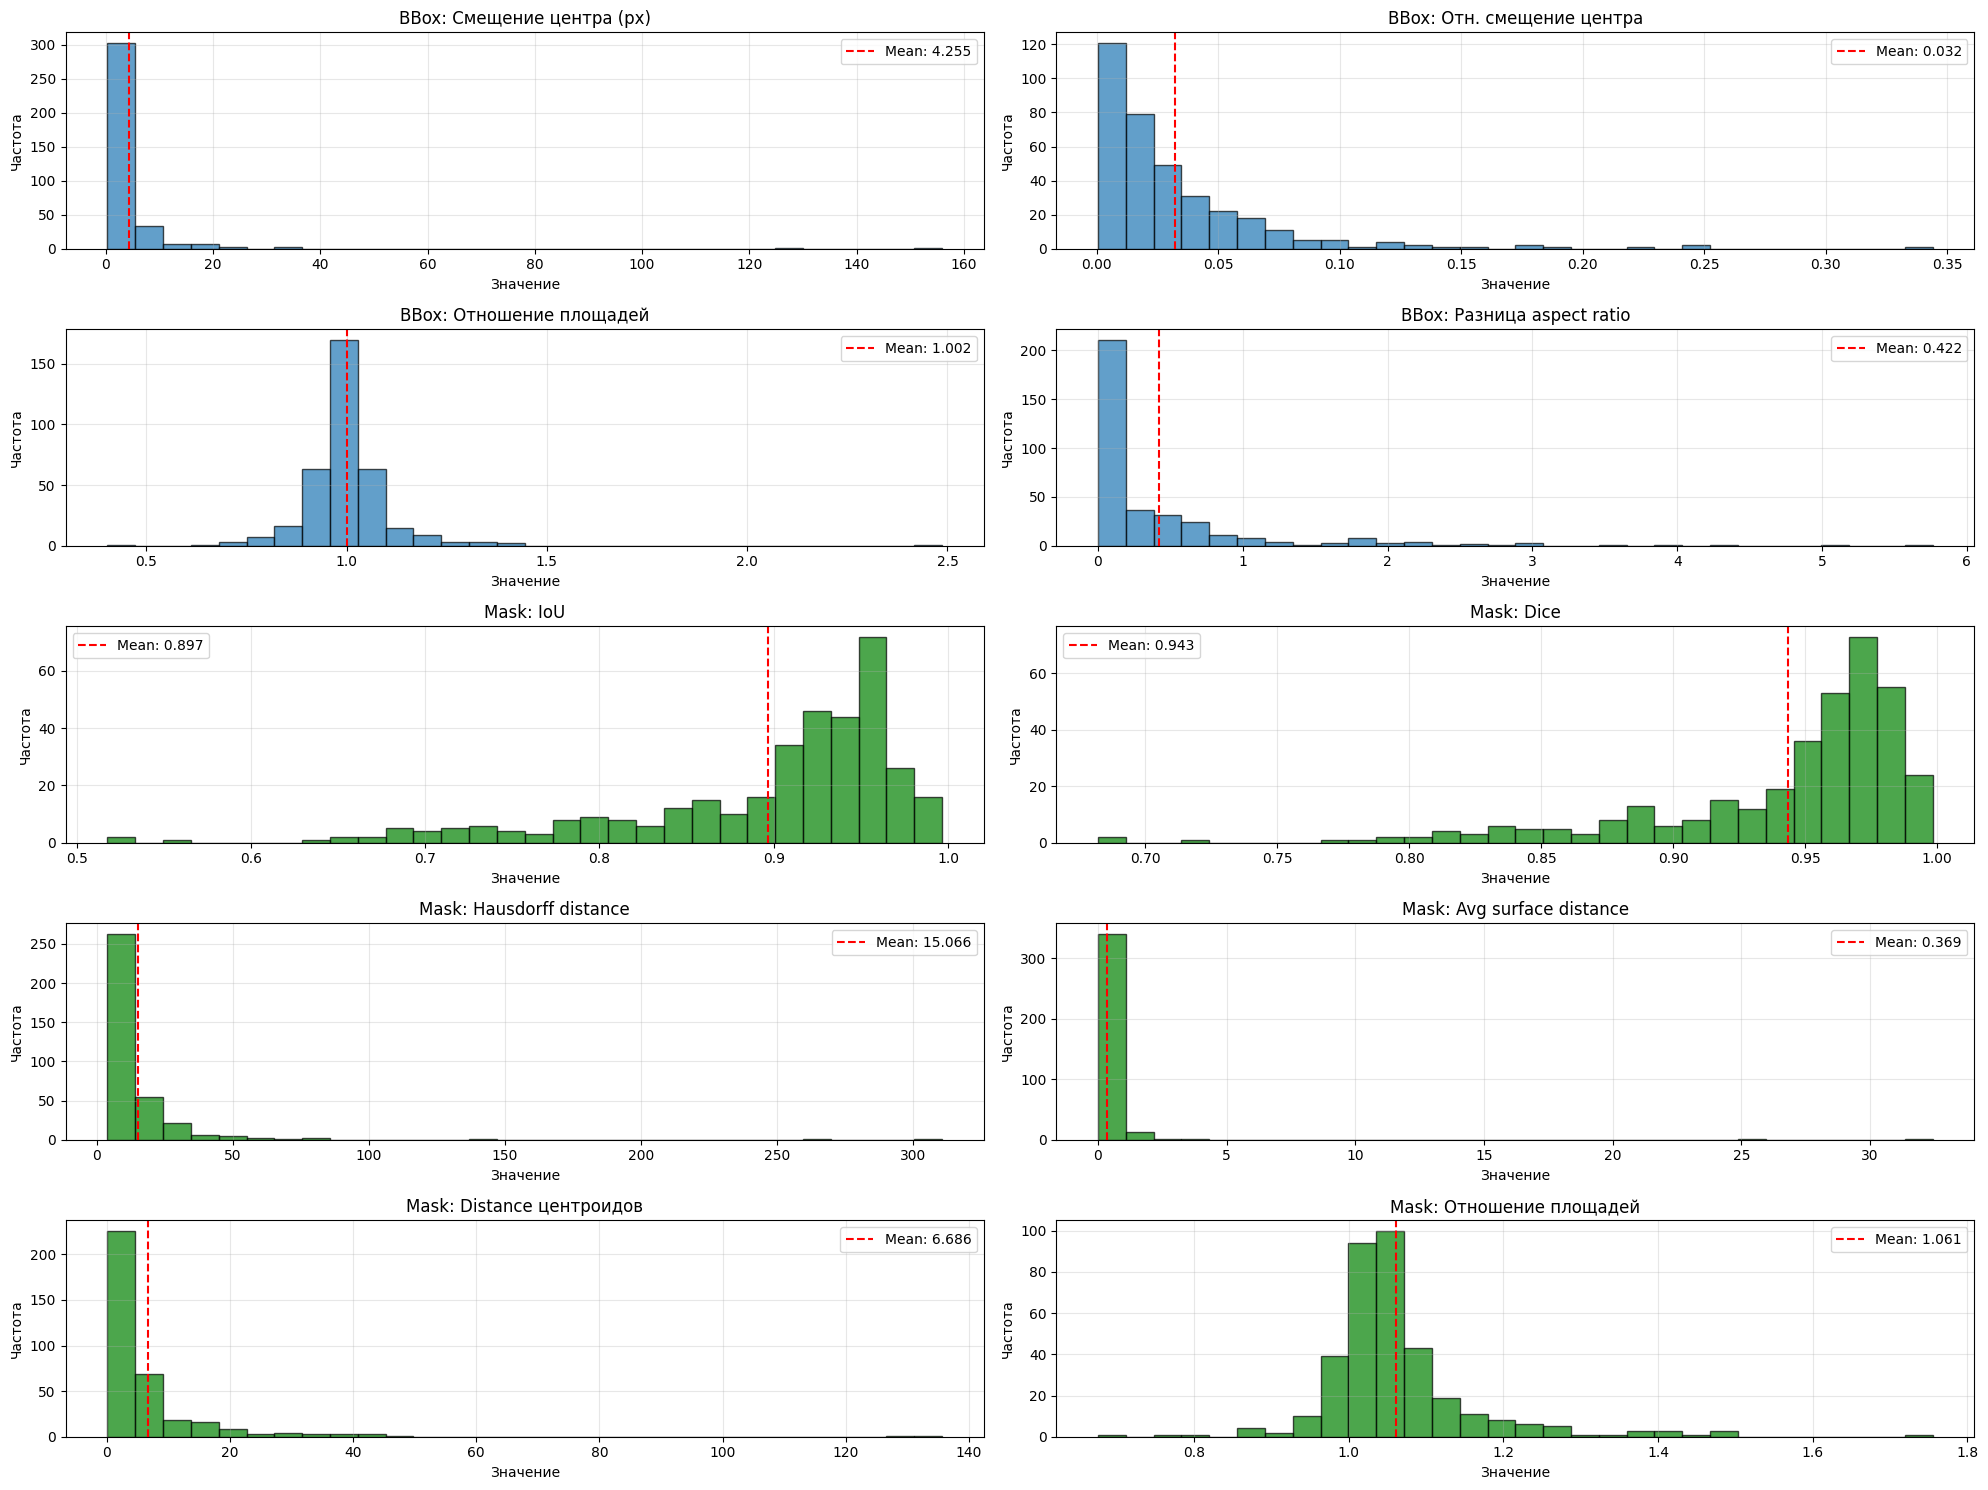

Статистический анализ отклонений
                                  mean      std  median     q25      q75  \
bbox_center_shift_px            4.2553  11.2894  2.1701  1.3085   3.7478   
bbox_center_shift_rel           0.0323   0.0399  0.0199  0.0079   0.0412   
bbox_size_ratio                 1.0016   0.1238  0.9962  0.9573   1.0300   
bbox_aspect_ratio_diff          0.4215   0.7664  0.1180  0.0114   0.5014   
mask_iou                        0.8969   0.0843  0.9255  0.8661   0.9532   
mask_dice                       0.9434   0.0510  0.9613  0.9282   0.9761   
mask_hausdorff_distance        15.0658  24.2110  9.8489  6.7082  14.7648   
mask_average_surface_distance   0.3694   2.1826  0.0807  0.0471   0.1910   
mask_centroid_distance          6.6856  12.3565  3.0102  1.5378   6.5901   
mask_area_ratio                 1.0613   0.1021  1.0420  1.0116   1.0797   

                                  min       max      cv  
bbox_center_shift_px           0.2605  155.9521  2.6530  
bbox_center_sh

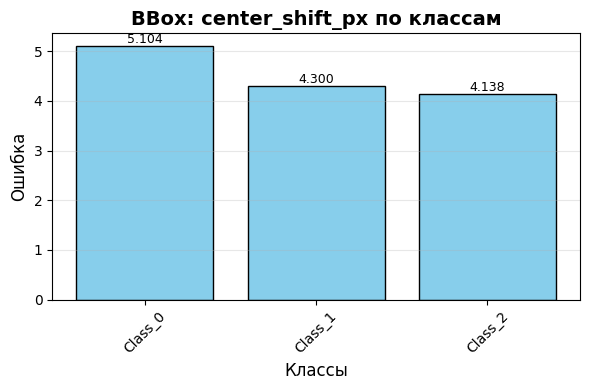

 BBox график сохранен: class_analysis_results/bbox_only_center_shift_rel.png


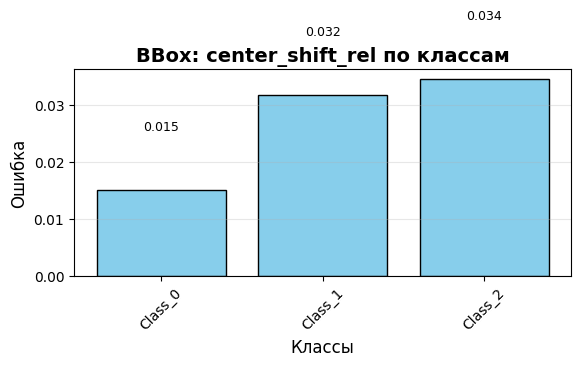

 BBox график сохранен: class_analysis_results/bbox_only_size_ratio.png


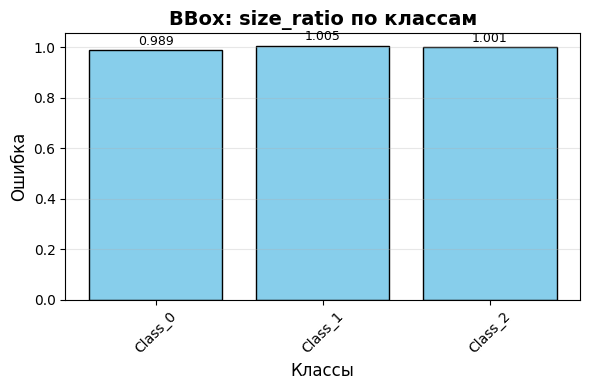

 BBox график сохранен: class_analysis_results/bbox_only_aspect_ratio_diff.png


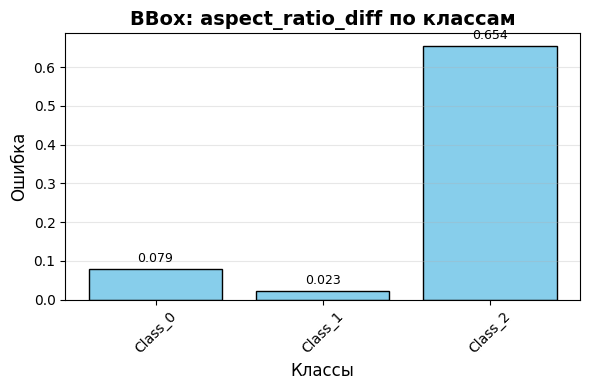

Графики для mask метрик
Mask график сохранен: class_analysis_results/mask_only_iou.png


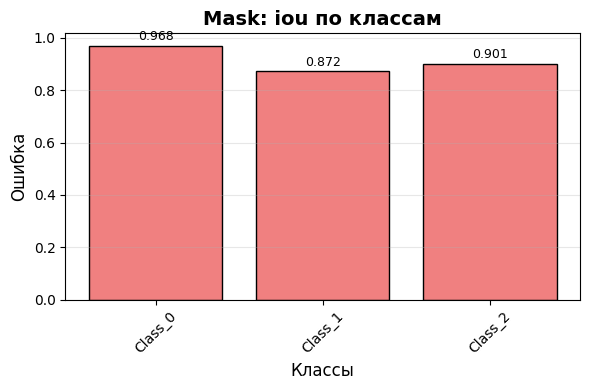

Mask график сохранен: class_analysis_results/mask_only_dice.png


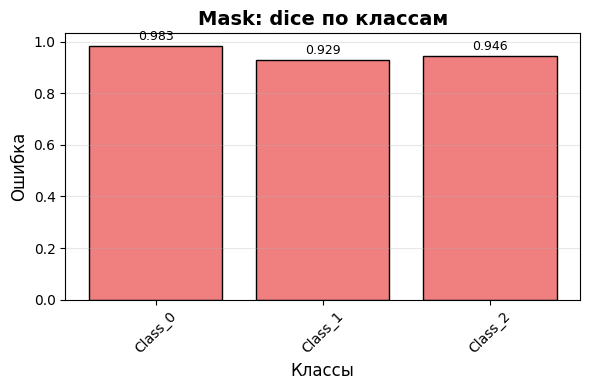

Mask график сохранен: class_analysis_results/mask_only_hausdorff_distance.png


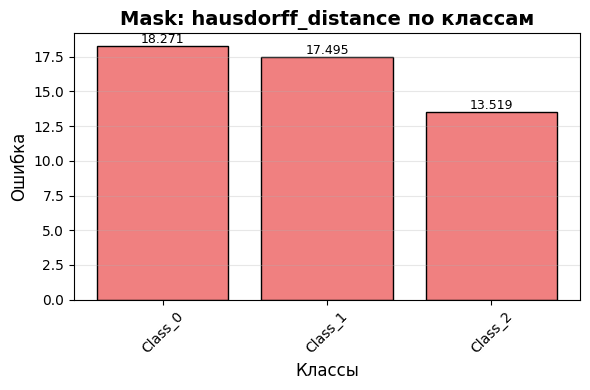

Mask график сохранен: class_analysis_results/mask_only_average_surface_distance.png


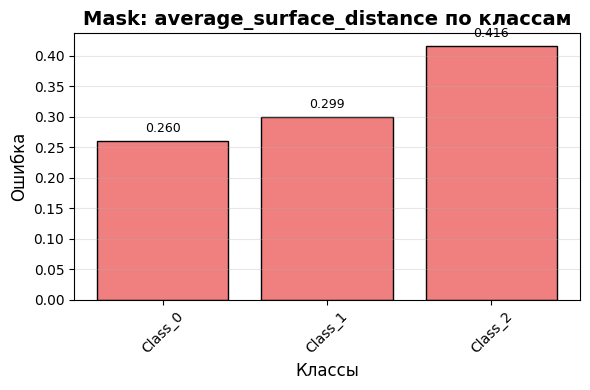

Mask график сохранен: class_analysis_results/mask_only_centroid_distance.png


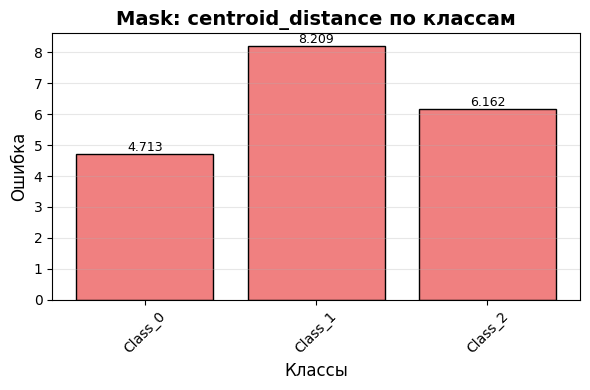

Mask график сохранен: class_analysis_results/mask_only_area_ratio.png


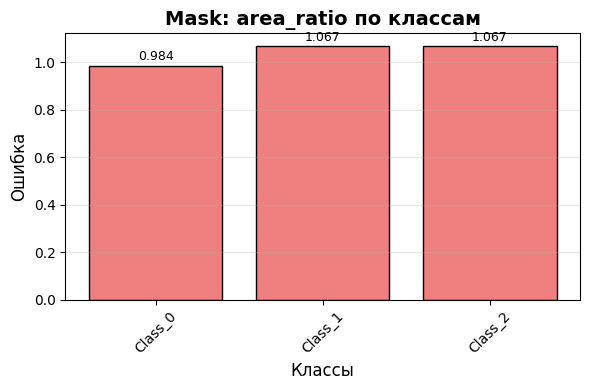

Статистика отклоненеий по классам

 Класс: Class_0 (ID: 0)
  bbox_center_shift_px           mean=5.1040, std=7.6887, n=25
  bbox_center_shift_rel          mean=0.0150, std=0.0240, n=25
  bbox_size_ratio                mean=0.9892, std=0.0537, n=25
  bbox_aspect_ratio_diff         mean=0.0789, std=0.1253, n=25
  mask_iou                       mean=0.9684, std=0.0500, n=25
  mask_dice                      mean=0.9833, std=0.0276, n=25
  mask_hausdorff_distance        mean=18.2708, std=16.1325, n=25
  mask_average_surface_distance  mean=0.2597, std=0.7496, n=25
  mask_centroid_distance         mean=4.7132, std=7.8076, n=25
  mask_area_ratio                mean=0.9839, std=0.0514, n=25

 Класс: Class_1 (ID: 1)
  bbox_center_shift_px           mean=4.2995, std=5.3703, n=109
  bbox_center_shift_rel          mean=0.0317, std=0.0349, n=109
  bbox_size_ratio                mean=1.0054, std=0.0887, n=109
  bbox_aspect_ratio_diff         mean=0.0235, std=0.1012, n=109
  mask_iou                  

In [18]:
test_dataset_path = '/content/drive/MyDrive/svik54.v3-prolog_1500.yolov11/valid'
results = evaluate_yolo_seg_deviations(model, test_dataset_path, conf_threshold=0.25)